In [1]:
import sys
assert sys.version_info >= (3, 5)

from collections import defaultdict
from datetime import datetime
import json
import logging
import os
from pathlib import Path
import random
import re
import sys
from typing import Dict, Tuple
import urllib
from zipfile import ZipFile

import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

# Load and preprocess data

In [2]:
!ls

20210101-20211213 ERCOT Day-Ahead Price.csv
DAM_analysis.ipynb


In [3]:
df = pd.read_csv ('20210101-20211213 ERCOT Day-Ahead Price.csv')

In [4]:
df.head

<bound method NDFrame.head of                         Date  price        zone
0       1/1/2021 12:00:00 AM  24.11      LZ_AEN
1       1/1/2021 12:00:00 AM  18.46      LZ_CPS
2       1/1/2021 12:00:00 AM  18.31  LZ_HOUSTON
3       1/1/2021 12:00:00 AM  18.95     LZ_LCRA
4       1/1/2021 12:00:00 AM  18.18    LZ_NORTH
...                      ...    ...         ...
66555  12/13/2021 4:00:00 PM  28.57     LZ_LCRA
66556  12/13/2021 4:00:00 PM  28.92    LZ_NORTH
66557  12/13/2021 4:00:00 PM  31.46    LZ_RAYBN
66558  12/13/2021 4:00:00 PM  31.54    LZ_SOUTH
66559  12/13/2021 4:00:00 PM  25.64     LZ_WEST

[66560 rows x 3 columns]>

In [5]:
df.dtypes


Date      object
price    float64
zone      object
dtype: object

In [7]:
df.zone.apply(str)


0            LZ_AEN
1            LZ_CPS
2        LZ_HOUSTON
3           LZ_LCRA
4          LZ_NORTH
            ...    
66555       LZ_LCRA
66556      LZ_NORTH
66557      LZ_RAYBN
66558      LZ_SOUTH
66559       LZ_WEST
Name: zone, Length: 66560, dtype: object

In [8]:
df.dtypes

Date      object
price    float64
zone      object
dtype: object

In [9]:
df['Date']= pd.to_datetime(df['Date'])

In [10]:
df.dtypes

Date     datetime64[ns]
price           float64
zone             object
dtype: object

In [11]:
df.head

<bound method NDFrame.head of                      Date  price        zone
0     2021-01-01 00:00:00  24.11      LZ_AEN
1     2021-01-01 00:00:00  18.46      LZ_CPS
2     2021-01-01 00:00:00  18.31  LZ_HOUSTON
3     2021-01-01 00:00:00  18.95     LZ_LCRA
4     2021-01-01 00:00:00  18.18    LZ_NORTH
...                   ...    ...         ...
66555 2021-12-13 16:00:00  28.57     LZ_LCRA
66556 2021-12-13 16:00:00  28.92    LZ_NORTH
66557 2021-12-13 16:00:00  31.46    LZ_RAYBN
66558 2021-12-13 16:00:00  31.54    LZ_SOUTH
66559 2021-12-13 16:00:00  25.64     LZ_WEST

[66560 rows x 3 columns]>

In [12]:
df = df [df['zone']=='LZ_NORTH']

In [13]:
df.head

<bound method NDFrame.head of                      Date  price      zone
4     2021-01-01 00:00:00  18.18  LZ_NORTH
12    2021-01-01 01:00:00  17.56  LZ_NORTH
20    2021-01-01 02:00:00  17.02  LZ_NORTH
28    2021-01-01 03:00:00  17.14  LZ_NORTH
36    2021-01-01 04:00:00  17.18  LZ_NORTH
...                   ...    ...       ...
66524 2021-12-13 12:00:00  24.76  LZ_NORTH
66532 2021-12-13 13:00:00  23.29  LZ_NORTH
66540 2021-12-13 14:00:00  20.89  LZ_NORTH
66548 2021-12-13 15:00:00  20.38  LZ_NORTH
66556 2021-12-13 16:00:00  28.92  LZ_NORTH

[8320 rows x 3 columns]>

# Play with different curtail threshold and ignore Feb for now

In [14]:
df['month'] = df['Date'].dt.month


<ipython-input-14-9aab43495f07>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['month'] = df['Date'].dt.month


In [15]:
df.head

<bound method NDFrame.head of                      Date  price      zone  month
4     2021-01-01 00:00:00  18.18  LZ_NORTH      1
12    2021-01-01 01:00:00  17.56  LZ_NORTH      1
20    2021-01-01 02:00:00  17.02  LZ_NORTH      1
28    2021-01-01 03:00:00  17.14  LZ_NORTH      1
36    2021-01-01 04:00:00  17.18  LZ_NORTH      1
...                   ...    ...       ...    ...
66524 2021-12-13 12:00:00  24.76  LZ_NORTH     12
66532 2021-12-13 13:00:00  23.29  LZ_NORTH     12
66540 2021-12-13 14:00:00  20.89  LZ_NORTH     12
66548 2021-12-13 15:00:00  20.38  LZ_NORTH     12
66556 2021-12-13 16:00:00  28.92  LZ_NORTH     12

[8320 rows x 4 columns]>

In [16]:
#ignore Feb
df = df [df['month'] != 2]

In [17]:
df.head

<bound method NDFrame.head of                      Date  price      zone  month
4     2021-01-01 00:00:00  18.18  LZ_NORTH      1
12    2021-01-01 01:00:00  17.56  LZ_NORTH      1
20    2021-01-01 02:00:00  17.02  LZ_NORTH      1
28    2021-01-01 03:00:00  17.14  LZ_NORTH      1
36    2021-01-01 04:00:00  17.18  LZ_NORTH      1
...                   ...    ...       ...    ...
66524 2021-12-13 12:00:00  24.76  LZ_NORTH     12
66532 2021-12-13 13:00:00  23.29  LZ_NORTH     12
66540 2021-12-13 14:00:00  20.89  LZ_NORTH     12
66548 2021-12-13 15:00:00  20.38  LZ_NORTH     12
66556 2021-12-13 16:00:00  28.92  LZ_NORTH     12

[7648 rows x 4 columns]>

In [18]:
df.describe()

,price,month
count,7648.000000,7648.000000
mean,36.378580,6.609963
std,41.676989,3.176297
min,0.140000,1.000000
25%,21.360000,4.000000
50%,29.290000,7.000000
75%,41.112500,9.000000
max,1497.800000,12.000000


In [33]:
df.groupby('month').mean()

,price
month,
1,21.757325
3,21.130767
4,30.515000
5,25.030094
6,42.798667
7,41.966532
8,42.333952
9,45.837375
10,54.628831


<AxesSubplot:xlabel='month'>

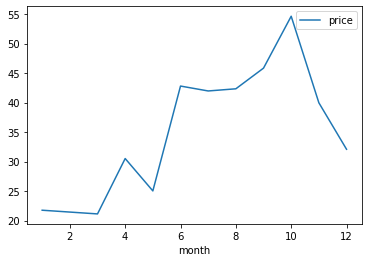

In [37]:
df.groupby('month').mean().plot(legend=True)

****************************************************************************************************
Curtail at 50
           price
month           
1      21.251049
3      20.114455
4      23.295657
5      24.158306
6      27.224281
7      30.201244
8      31.929072
9      34.297750
10     38.795104
11     33.371073
12     29.017651
Overall Average  27.72333024118747
Uptime percentage  0.8457112970711297
****************************************************************************************************
Curtail at 55
           price
month           
1      21.424431
3      20.376881
4      23.698079
5      24.536277
6      27.775039
7      31.330233
8      33.213984
9      35.842653
10     40.070056
11     34.594797
12     29.666263
Overall Average  28.665643122676645
Uptime percentage  0.8793148535564853
****************************************************************************************************
Curtail at 60
           price
month           
1      21.569204
3      20.57714

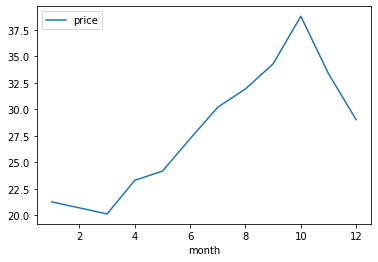

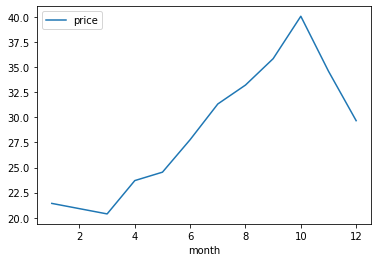

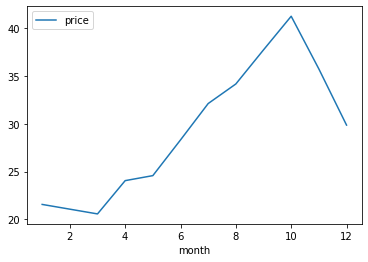

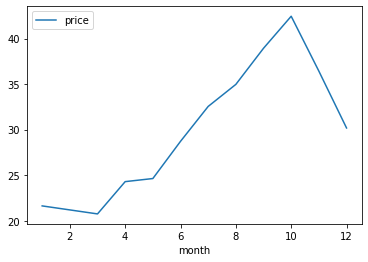

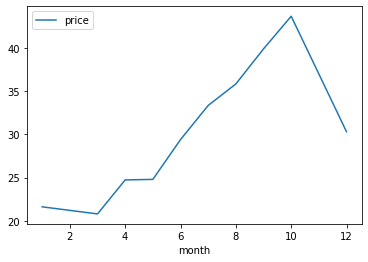

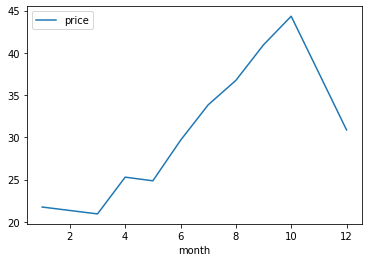

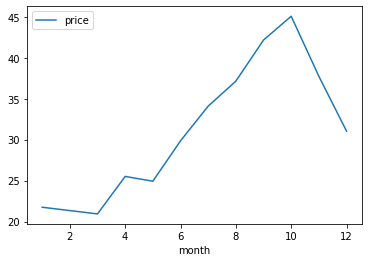

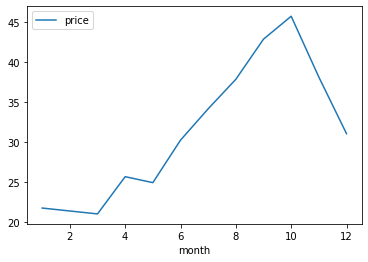

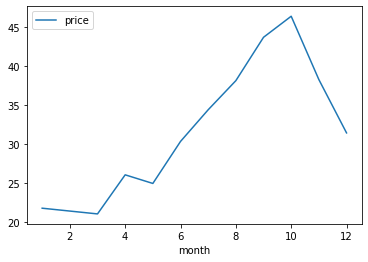

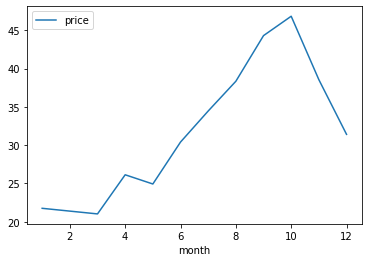

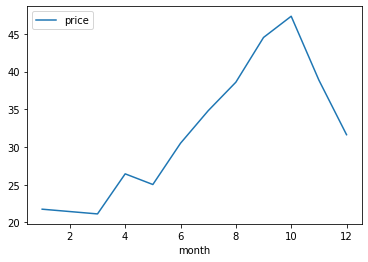

In [43]:

curtail_analysis = pd.DataFrame(columns = ['curtail', 'average', 'uptime'])

for curtail in range(50,105, 5):
    print("*"*100)
    print("Curtail at "+ str(curtail))
    df_curtail = df [df['price'] <= curtail]
    print(df_curtail.groupby('month').mean())
    df_curtail.groupby('month').mean().plot(legend=True)
    print("Overall Average ", df_curtail['price'].mean())
    print("Uptime percentage ", df_curtail['Date'].count()/df['Date'].count())
    curtail_analysis = curtail_analysis.append({'curtail' : curtail, 'average' :df_curtail['price'].mean(), 'uptime' : df_curtail['Date'].count()/df['Date'].count()}, 
                ignore_index = True)
                                           

In [44]:
curtail_analysis.head

<bound method NDFrame.head of     curtail    average    uptime
0      50.0  27.723330  0.845711
1      55.0  28.665643  0.879315
2      60.0  29.472114  0.904942
3      65.0  30.086707  0.922333
4      70.0  30.720825  0.938285
5      75.0  31.263819  0.950706
6      80.0  31.626783  0.958290
7      85.0  31.969808  0.964827
8      90.0  32.266915  0.970058
9      95.0  32.478046  0.973457
10    100.0  32.722996  0.977118>

In [63]:
curtail_analysis

,curtail,average,uptime
0,50.0,27.723330,0.845711
1,55.0,28.665643,0.879315
2,60.0,29.472114,0.904942
3,65.0,30.086707,0.922333
4,70.0,30.720825,0.938285
5,75.0,31.263819,0.950706
6,80.0,31.626783,0.958290
7,85.0,31.969808,0.964827
8,90.0,32.266915,0.970058
9,95.0,32.478046,0.973457


<AxesSubplot:title={'center':'Average after curtail'}, xlabel='curtail'>

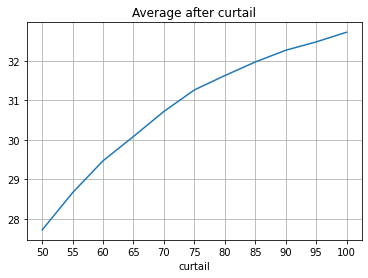

In [58]:
curtail_analysis.plot(x ='curtail', y='average', kind = 'line', title="Average after curtail", 
                      xticks=range(50,105,5),
                      grid=True, legend=False)


<AxesSubplot:title={'center':'Uptime after curtail'}, xlabel='curtail'>

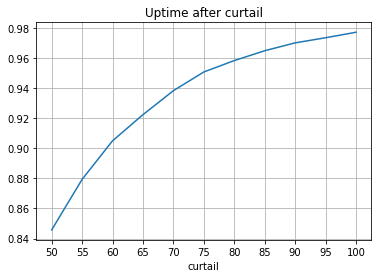

In [62]:
curtail_analysis.plot(x ='curtail', y='uptime', kind = 'line', title="Uptime after curtail", 
                      xticks=range(50,105,5),
                      #yticks=range(0.84,1.0,0.02),
                      grid=True, legend=False)
